In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.linalg import sqrtm



In [2]:
goog = yf.Ticker('GOOG')
data = goog.history(period='3mo')
display(data)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-02-22 00:00:00-05:00,91.933998,92.360001,90.870003,91.800003,29891100,0.0,0.0
2023-02-23 00:00:00-05:00,92.129997,92.129997,90.010002,91.070000,32423700,0.0,0.0
2023-02-24 00:00:00-05:00,89.629997,90.129997,88.860001,89.349998,31295600,0.0,0.0
2023-02-27 00:00:00-05:00,90.089996,90.449997,89.610001,90.099998,22724300,0.0,0.0
2023-02-28 00:00:00-05:00,89.540001,91.449997,89.519997,90.300003,30546900,0.0,0.0
...,...,...,...,...,...,...,...
2023-05-16 00:00:00-04:00,116.830002,121.199997,116.830002,120.089996,32370100,0.0,0.0
2023-05-17 00:00:00-04:00,120.180000,122.279999,119.459999,121.480003,26659600,0.0,0.0
2023-05-18 00:00:00-04:00,121.559998,123.900002,121.489998,123.519997,27014500,0.0,0.0


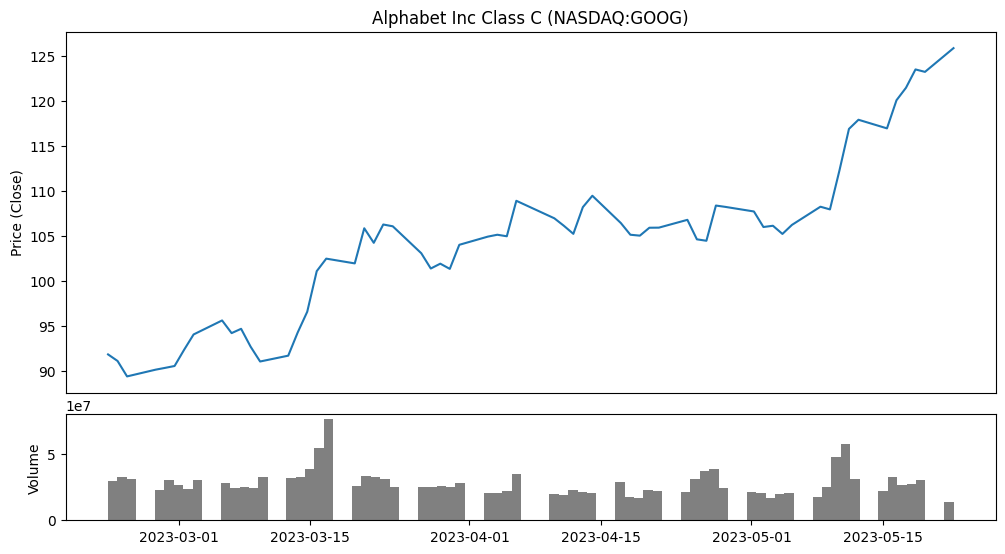

In [3]:
top_plt = plt.subplot2grid((5,4), (0, 0), rowspan=3, colspan=4)
top_plt.plot(data.index, data["Close"])
top_plt.set_ylabel('Price (Close)')
top_plt.set_xticks([])
plt.title('Alphabet Inc Class C (NASDAQ:GOOG)')
bottom_plt = plt.subplot2grid((5,4), (3,0), rowspan=1, colspan=4)
bottom_plt.bar(data.index, data['Volume'], width=1, color="grey")
bottom_plt.set_ylabel('Volume')
plt.gcf().set_size_inches(12,8)



In [25]:
average_daily_volume = np.mean(data['Volume'])
average_daily_spread = np.mean(data['High'] - data['Low'])

sigma = np.std(data['Close'])
epsilon = average_daily_spread/2
eta = average_daily_spread/(0.01*average_daily_volume)
gamma = average_daily_spread/(0.1*average_daily_volume)
tau = 1

params = {
    'lambda': *1e-08,
    'sigma': sigma,
    'epsilon': epsilon,
    'eta': eta,
    'gamma': gamma,
    'tau': tau
}

print('Parameters:')
for k,v in params.items():
    print('  {} = {}'.format(k,v))



SyntaxError: cannot use a starred expression in a dictionary value (3000762436.py, line 11)

In [28]:
class AlmgrenChriss1D:
    
    def __init__(self, params):
        # Initialize Parameters
        self._lambda = params['lambda']
        self._sigma = params['sigma']
        self._epsilon = params['epsilon']
        self._eta = params['eta']
        self._gamma = params['gamma']
        self._tau = params['tau']
        
        self._eta_tilda = self._eta - 0.5*self._gamma*self._tau
        
        # Ensure Quadratic (for optimization)
        assert self._eta_tilda > 0
        
        self._kappa_tilda_squared = (self._lambda*self._sigma**2)/self._eta_tilda
        
        self._kappa = np.cosh(0.5*(self._kappa_tilda_squared*self._tau**2) + 1)/self._tau
        
    def trajectory(self, X, T):
        # Optimal Liquidation Trajectory
        ans = []
        for t in range(T):
            x = int(np.sinh(self._kappa*(T - t))/np.sinh(self._kappa*T)*X)
            ans.append(x)
        ans.append(0)
        return np.array(ans)
    
    def strategy(self, X, T):
        # Optimal Liquidation Trade List
        return np.diff(self.trajectory(X,T))



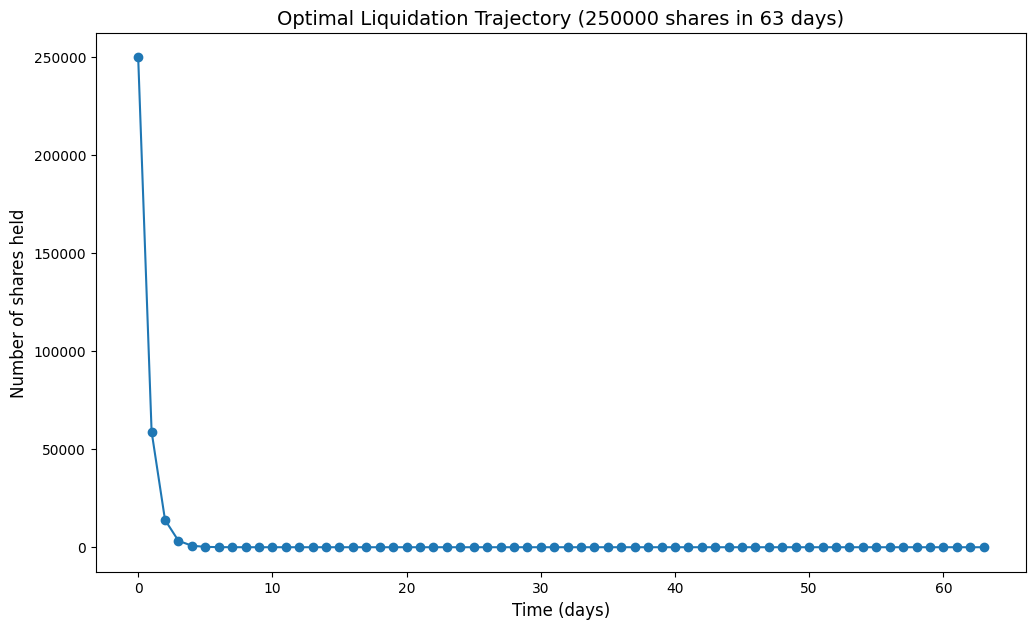

In [29]:
X = 250000
T = len(data)

model = AlmgrenChriss1D(params)
trajectory = model.trajectory(X,T)

plt.figure(figsize=(12,7))
plt.plot(range(T+1),trajectory,'o-')
plt.title(f'Optimal Liquidation Trajectory ({X} shares in {T} days)',fontsize=14)
plt.xlabel('Time (days)', fontsize=12)
plt.ylabel('Number of shares held', fontsize=12)
plt.show()

In [30]:
lambdas = [1e-2, 1e-7]

plt.figure(figsize=(12,7))
for _lambda in lambdas:
    new_params = params.copy()
    new_params['lambda'] = _lambda
    model = AlmgrenChriss1D(new_params)
    trajectory = model.trajectory(X,T)
    plt.plot(range(T + 1),trajectory,'o-',ms=4, label=f'$\lambda$ = {_lambda}')
plt.title(f'Optimal Liquidation Trajectory ({X} shares in {T} days)',fontsize=14)
plt.xlabel('Time (days)', fontsize=12)
plt.ylabel('Number of shares held', fontsize=12)
plt.legend()
plt.show()

C:\Users\jeope\AppData\Local\Temp\ipykernel_4752\1617040336.py:19: RuntimeWarning: overflow encountered in cosh
  self._kappa = np.cosh(0.5*(self._kappa_tilda_squared*self._tau**2) + 1)/self._tau
C:\Users\jeope\AppData\Local\Temp\ipykernel_4752\1617040336.py:25: RuntimeWarning: invalid value encountered in scalar divide
  x = int(np.sinh(self._kappa*(T - t))/np.sinh(self._kappa*T)*X)


ValueError: cannot convert float NaN to integer

<Figure size 1200x700 with 0 Axes>